<a href="https://colab.research.google.com/github/PavelNovikov888/classification_NBC/blob/master/%D0%9B%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F_%D0%91%D0%B0%D0%B9%D0%B5%D1%81_%D0%BF%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B4%D0%BE%D1%85%D0%BE%D0%B4%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install bambi
!pip install arviz

In [2]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
import warnings

from scipy.special import expit as invlogit

# Disable a FutureWarning in ArviZ at the moment of running the notebook
az.style.use("arviz-darkgrid")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Подготовка данных

Набор данных о взрослых состоит из данных переписи населения США 1994 года.

Ниже приводится описание переменных в наборе данных.

 - age : Возраст человека
 - workclass : класс труда.
 - fnlwgt : не указано, но мы предполагаем, что это окончательный вес выборки.
 - education : Уровень образования как категориальная переменная.
 - education_num : Уровень образования как числовая переменная. Это не отражает годы обучения.
 - marital_status : Семейное положение.
 - occupation : Род занятий.
 - relationship : Отношения с главой семьи.
 - race : индивидуальная раса.
 - sex : пол человека.
 - Capital_gain : Прирост капитала в течение неопределенного периода времени.
 - Capital_loss : Убыток капитала в течение неопределенного периода времени.
 - hs_week : Часы работы в неделю.
 - native_country : Страна рождения.
 - income : доход как двоичная переменная (ниже или выше 50 тыс. в год).

In [3]:
raw_data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None,
    names=[
        "age",
        "workclass",
        "fnlwgt",
        "education-categorical",
        "educ",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "captial-gain",
        "capital-loss",
        "hours",
        "native-country",
        "income",
    ],
)

In [4]:
raw_data.head(10)

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age                    32561 non-null  int64 
 1   workclass              32561 non-null  object
 2   fnlwgt                 32561 non-null  int64 
 3   education-categorical  32561 non-null  object
 4   educ                   32561 non-null  int64 
 5   marital-status         32561 non-null  object
 6   occupation             32561 non-null  object
 7   relationship           32561 non-null  object
 8   race                   32561 non-null  object
 9   sex                    32561 non-null  object
 10  captial-gain           32561 non-null  int64 
 11  capital-loss           32561 non-null  int64 
 12  hours                  32561 non-null  int64 
 13  native-country         32561 non-null  object
 14  income                 32561 non-null  object
dtypes: int64(6), object

In [6]:
# тильда означает, что в data войдут все наблюдения, где income != np.nan
data = raw_data[~pd.isnull(raw_data["income"])]

In [7]:
data.head(3)

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [8]:
data[data["native-country"] == " United-States"].sample(5)

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
17683,36,Private,222584,HS-grad,9,Divorced,Adm-clerical,Unmarried,Black,Female,0,0,40,United-States,<=50K
16608,39,Private,218490,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1977,40,United-States,>50K
29174,41,Private,180138,HS-grad,9,Never-married,Sales,Not-in-family,White,Male,0,0,50,United-States,<=50K
28152,19,Private,210308,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,15,United-States,<=50K
28707,24,Private,306460,HS-grad,9,Never-married,Farming-fishing,Unmarried,White,Male,0,0,40,United-States,<=50K


In [9]:
# преобразуем целевой признак для классификации
income = 1 * (data["income"] == " >50K")

В этом примере мы используем только следующие переменные:  age, education, hours, marital-status, income.

In [10]:
data = data[["age", "educ", "hours","marital-status"]]

# Scale age by 10, it helps with model convergence.
data.loc[:,"age"] = data["age"] / 10.0
# возраст в квадрате
data.loc[:,"age2"] = np.square(data["age"])
data.loc[:,"income"] = income

income.value_counts()

0    24720
1     7841
Name: income, dtype: int64

In [11]:
data.head(3)

,age,educ,hours,marital-status,age2,income
0,3.9,13,40,Never-married,15.21,0
1,5.0,13,13,Married-civ-spouse,25.00,0
2,3.8,9,40,Divorced,14.44,0


In [12]:
# преобразуем признак martial-status в числовой
def replace_marital(marital):
    if 'married' in marital.lower():
        return 4
    elif 'single' in marital.lower():
        return 3
    elif 'divorced' in marital.lower():
        return 2
    elif 'unknown' in marital.lower():
        return 1

data['marital'] = data["marital-status"].apply(lambda x: replace_marital(x))

data['marital'].fillna(1, inplace=True)

In [13]:
data.head(3)

,age,educ,hours,marital-status,age2,income,marital
0,3.9,13,40,Never-married,15.21,0,4.0
1,5.0,13,13,Married-civ-spouse,25.00,0,4.0
2,3.8,9,40,Divorced,14.44,0,2.0


Мы будем использовать модель логистической регрессии, чтобы оценить вероятность заработать более 50 тысяч долларов в зависимости от возраста, семейного статуса и уровня образования.

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-16.293,0.222,-16.700,-15.877,0.008,0.006,754.0,1037.0,1.00
age,3.683,0.082,3.521,3.828,0.003,0.002,827.0,873.0,1.01
age2,-0.351,0.009,-0.366,-0.332,0.000,0.000,846.0,725.0,1.01
marital,0.804,0.022,0.763,0.846,0.001,0.000,1118.0,1202.0,1.00
educ,0.335,0.007,0.323,0.347,0.000,0.000,1449.0,1301.0,1.00


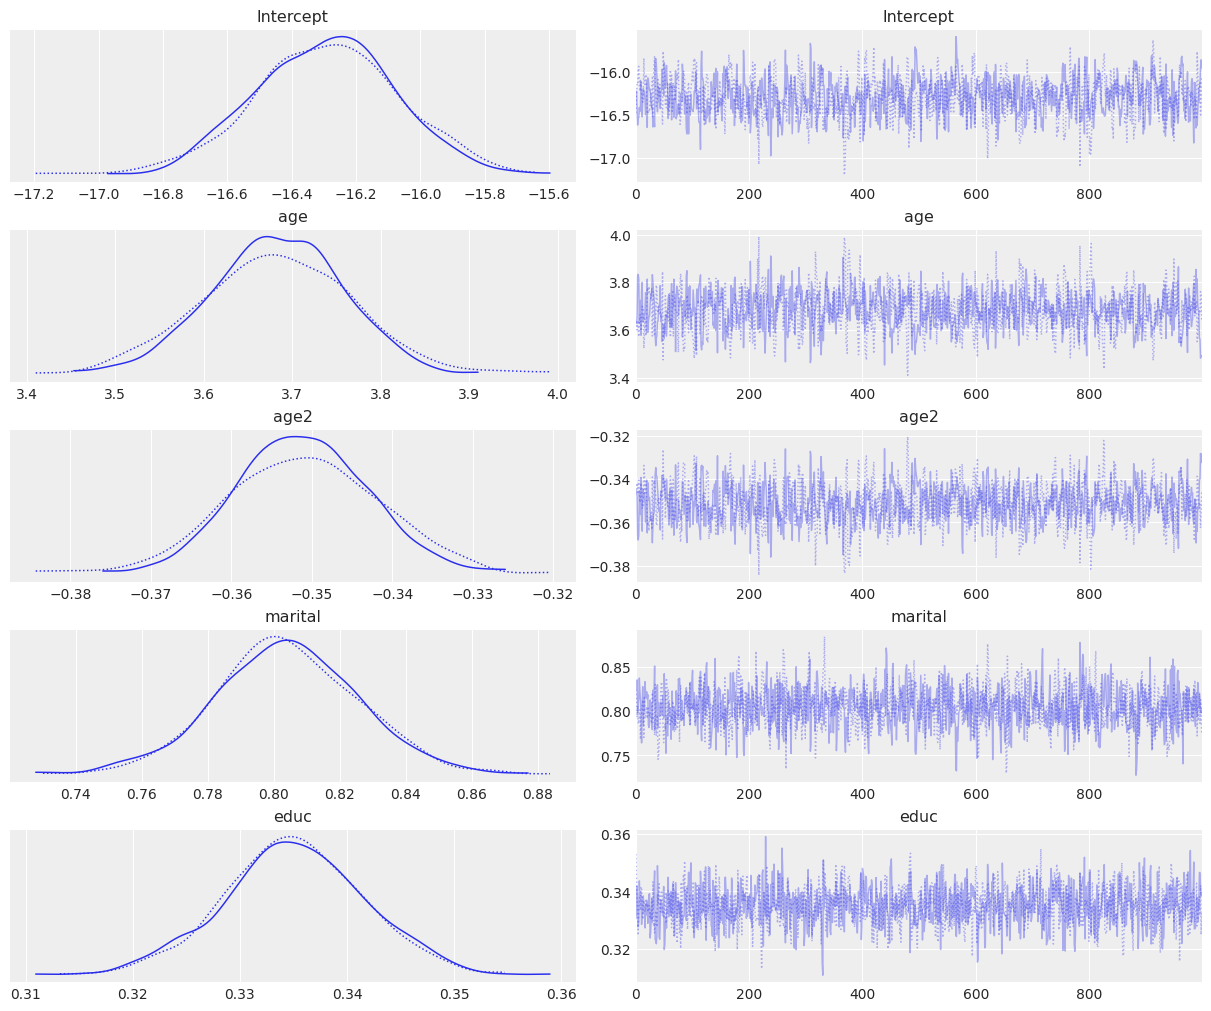

In [14]:
model = bmb.Model('income ~ age + age2 + marital + educ ', data, family="bernoulli")
# Fit the model using 1000 on each of 4 chains
# results = model.fit(draws=1000, chains=4)
results = model.fit(draws=1000, idata_kwargs={"log_likelihood": True})

# Use ArviZ to plot the results
az.plot_trace(results)

# Key summary and diagnostic info on the model parameters
az.summary(results)

In [15]:
from __future__ import annotations

import warnings

from typing import TYPE_CHECKING, Any, Callable

# import matplotlib.pyplot as plt
# import numpy as np

from pymc.backends.base import MultiTrace

if TYPE_CHECKING:
    from arviz.data.inference_data import InferenceData


def plot_posterior_predictive_glm(
    trace: InferenceData | MultiTrace,
    eval: np.ndarray | None = None,
    lm: Callable | None = None,
    samples: int = 30,
    **kwargs: Any
) -> None:
    """
    Построение апостериорного предсказания линейной модели.

    Параметры
    ----------
    trace: InferenceData или MultiTrace
        Выходные данные pm.sample()
    eval: <array>
        Массив, над которым будет производиться оценка lm
    lm: функция <default: линейная функция>
        Функция, отображающая параметры в различных точках
        к соответствующим выходам.
        input: point, sample
        output: estimated value
    samples: int <default=30>
        Сколько апостериорных выборок нужно построить.
    kwargs : mapping,  optional
        Дополнительные аргументы в виде ключевых слов, передаваемые в ``matplotlib.pyplot.plot()``.

    Plot posterior predictive of a linear model.

    Parameters
    ----------
    trace: InferenceData or MultiTrace
        Output of pm.sample()
    eval: <array>
        Array over which to evaluate lm
    lm: function <default: linear function>
        Function mapping parameters at different points
        to their respective outputs.
        input: point, sample
        output: estimated value
    samples: int <default=30>
        How many posterior samples to draw.
    kwargs : mapping, optional
        Additional keyword arguments are passed to ``matplotlib.pyplot.plot()``.
    """
    if lm is None:
        lm = lambda x, sample: sample["Intercept"] + sample["x"] * x

    if eval is None:
        eval = np.linspace(0, 1, 100)

    # Set default plotting arguments
    if "lw" not in kwargs and "linewidth" not in kwargs:
        kwargs["lw"] = 0.2
    if "c" not in kwargs and "color" not in kwargs:
        kwargs["c"] = "k"

    if not isinstance(trace, MultiTrace):
        trace = trace.posterior.to_dataframe().to_dict(orient="records")

    for rand_loc in np.random.randint(0, len(trace), samples):
        rand_sample = trace[rand_loc]
        plt.plot(eval, lm(eval, rand_sample), **kwargs)
        # Make sure to not plot label multiple times
        kwargs.pop("label", None)

    plt.title("Posterior predictive")

In [21]:
trace = results

In [17]:
# trace

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1760: UserWarning: The figure layout has changed to tight
  f.tight_layout()
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1761: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  f.subplots_adjust(hspace=space, wspace=space)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)


<Figure size 900x700 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


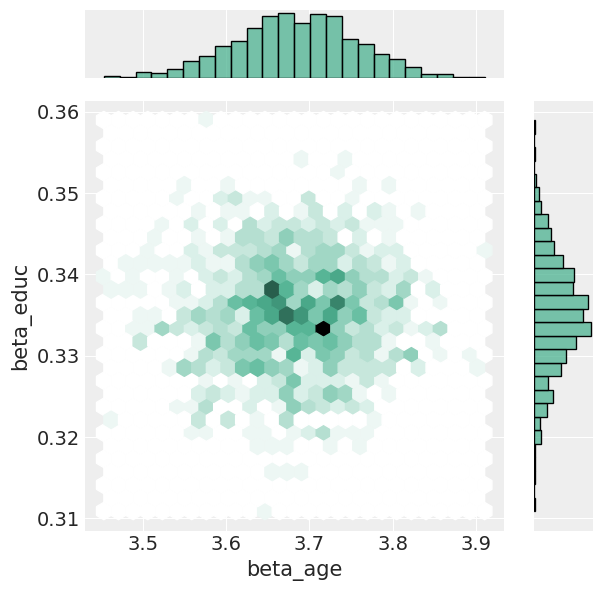

In [28]:
plt.figure(figsize=(9, 7))
sns.jointplot(x = trace.posterior["age"][0], y =  trace.posterior["educ"][0],  kind="hex", color="#4CB391")
plt.xlabel("beta_age")
plt.ylabel("beta_educ");

Итак, влияют ли возраст и образование на вероятность заработать больше, чем 50 К?

# Оценка вероятности

В этом разделе мы строим график зависимости возраста от вероятности заработка более 50 тысяч в год.
Чтобы ответить на этот вопрос мы покажем что вероятность получить больше 50% меняется с возрастом и семейным положением для нескольких уровней образования.

 Bambi дает нам удобный способ построить апостериорное прогнозирующее распределение. Нам нужно передать функции линейную модель и набор точекдля оценки. Мы перейдём к трем различным линейным моделям: одна с образованием --12(законченая средняя школа), одна с образованием -- 16(окончание бакалавриата) и одна с образованием -- 19(трехгодичная аспирантура).

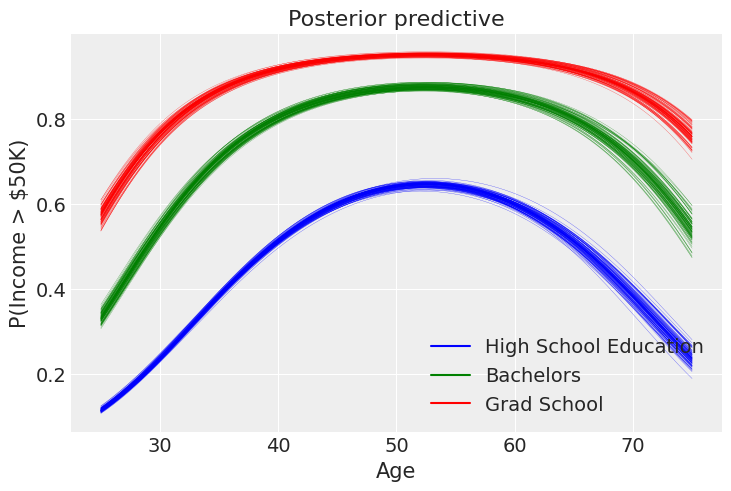

In [22]:
def lm_full(trace, age, education, marital):
    shape = np.broadcast(age, education, marital).shape
    x_norm = np.asarray([np.broadcast_to(x, shape) for x in [age/10., education, marital]])

    return 1 / (1 + np.exp(-(trace['Intercept'] +
                             trace['age']*x_norm[0] +
                             trace['age2']*(x_norm[0]**2) +
                             trace['educ']*x_norm[1] +
                             trace['marital']*x_norm[2])))

# разные уровни образования(12,16,19), но фиксируем семейное положение(4)
lm = lambda x, samples: lm_full(samples, x, 12., 4.)
lm2 = lambda x, samples: lm_full(samples, x, 16., 4.)
lm3 = lambda x, samples: lm_full(samples, x, 19., 4.)


plot_posterior_predictive_glm(trace, eval=np.linspace(25,75,1000), lm=lm, samples=100, color='blue', alpha=.8)
plot_posterior_predictive_glm(trace, eval=np.linspace(25,75,1000), lm=lm2, samples=100, color='green', alpha=.8)
plot_posterior_predictive_glm(trace, eval=np.linspace(25,75,1000), lm=lm3, samples=100, color='red', alpha=.8)

blue_line = mlines.Line2D(["lm"], [], color="b", label="High School Education")
green_line = mlines.Line2D(["lm2"], [], color="g", label="Bachelors")
red_line = mlines.Line2D(["lm3"], [], color="r", label="Grad School")
plt.legend(handles=[blue_line, green_line, red_line], loc="lower right")
plt.ylabel("P(Income > $50K)")
plt.xlabel("Age")
plt.show();

Три кривые на графике. Каждая кривая показывает, насколько вероятность заработать больше, чем 50К меняется с возрастом. Красная кривая представляет 19 лет образования, зелёная кривая представляет 16 лет образования, а синяя кривая представляет 12 лет образования. Для всех трех уровней образования вероятность заработка более 50 тысяч увеличивается с возрастом примерно до 60 лет, когда вероятность начинает снижаться, Обращаем внимание, что каждая кривая немного размыта. Это потому что мы фактически строим 100 различных кривых для каждого уровня образования. Каждая кривая является результатом нашего апостериорного распределения. Поскольку кривые в некоторой степени полупрозрачны, мы можем интерпретировать темные узкие участки прямой как места, где у нас низкая неопределённость, а светлые, расширеныые участки кривой как места, где у нас низкая неоределённость, а светлые, расширенные участки кривой - как места, где у нас есть несколько более высокоя неопределённость в отношении значений наших коэффицентов.  

In [23]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-16.293,0.222,-16.700,-15.877,0.008,0.006,754.0,1037.0,1.00
age,3.683,0.082,3.521,3.828,0.003,0.002,827.0,873.0,1.01
age2,-0.351,0.009,-0.366,-0.332,0.000,0.000,846.0,725.0,1.01
marital,0.804,0.022,0.763,0.846,0.001,0.000,1118.0,1202.0,1.00
educ,0.335,0.007,0.323,0.347,0.000,0.000,1449.0,1301.0,1.00


# Логистическая регрессия

In [24]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(data[['age', 'educ',  'age2', 'marital']], data['income'])

LogisticRegression()

In [25]:
lr.intercept_

array([-16.26445812])

In [26]:
pd.DataFrame(lr.coef_[0], index=['age', 'educ',  'age2', 'marital'])

,0
age,3.669533
educ,0.335039
age2,-0.349695
marital,0.803746


Коэффиценты похожи, но тем не менее немного отличаются.